In [31]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library import QFTGate, grover_operator, MCMTGate, ZGate, HGate
from qiskit import QuantumCircuit
from math import floor, pi
import pandas as pd
from qiskit_aer import AerSimulator
import qiskit
from qiskit.visualization import plot_histogram
from lib.lib import oracle
from plots import QC, QSubsetSum

%matplotlib inline

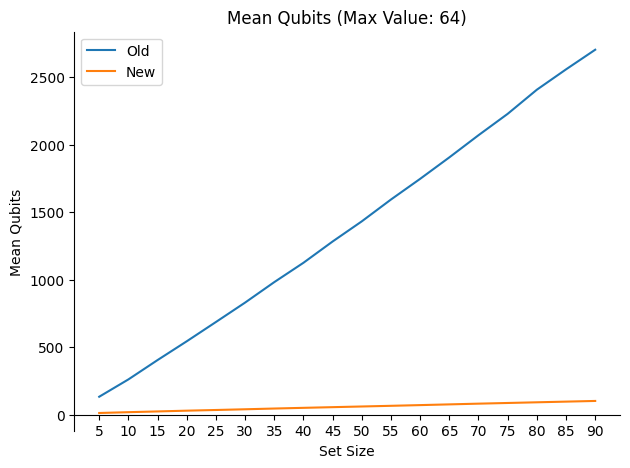

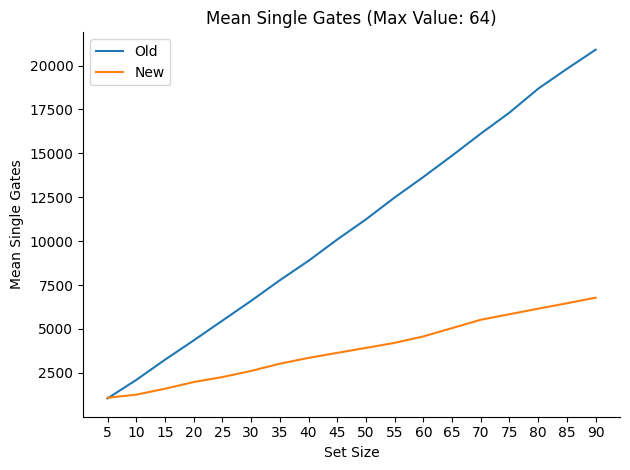

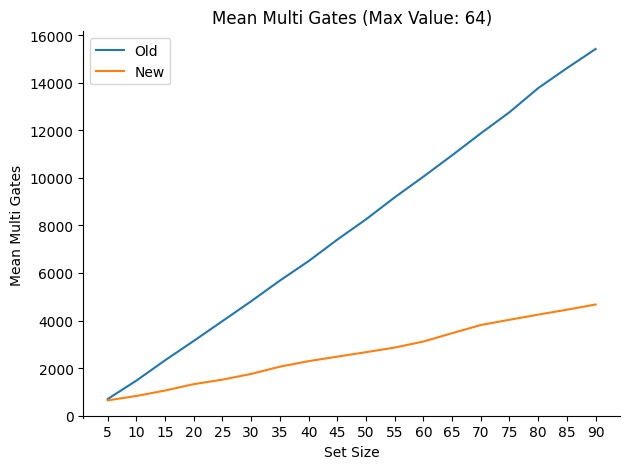

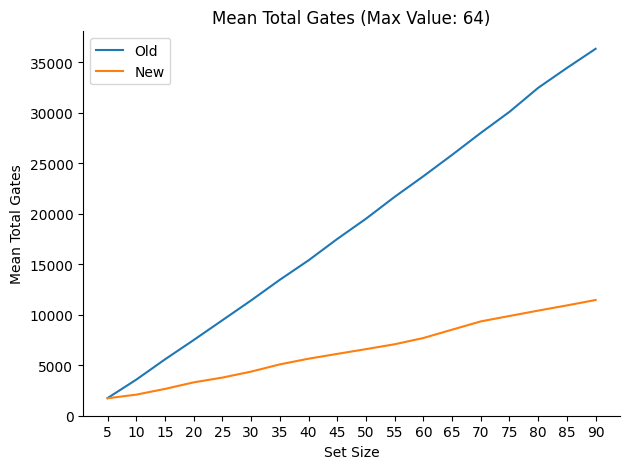

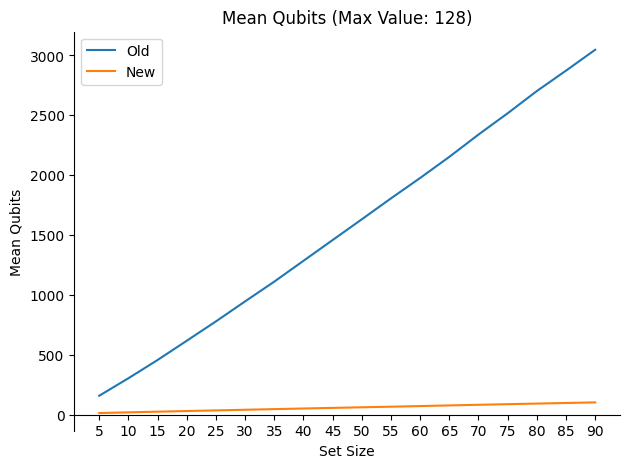

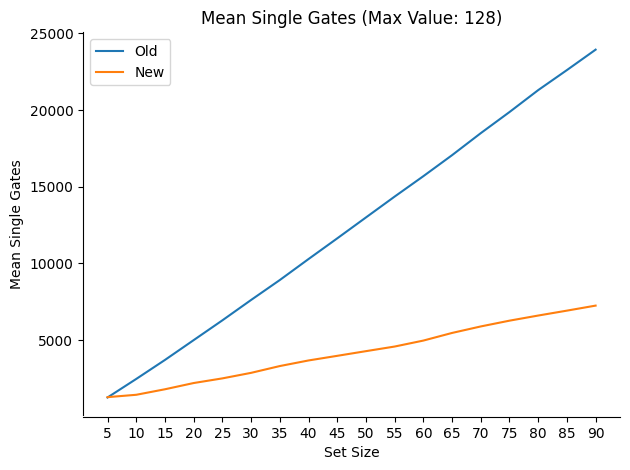

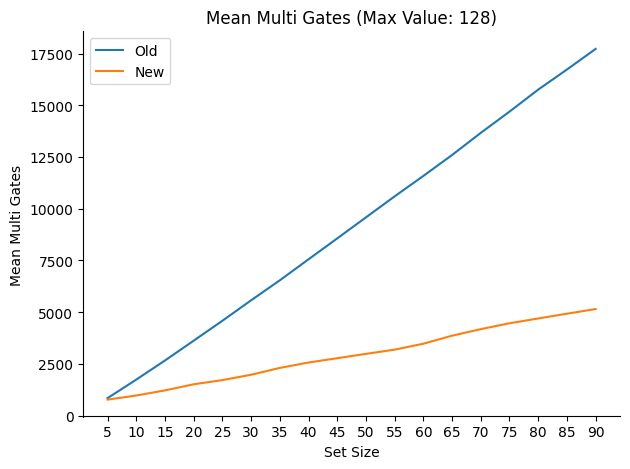

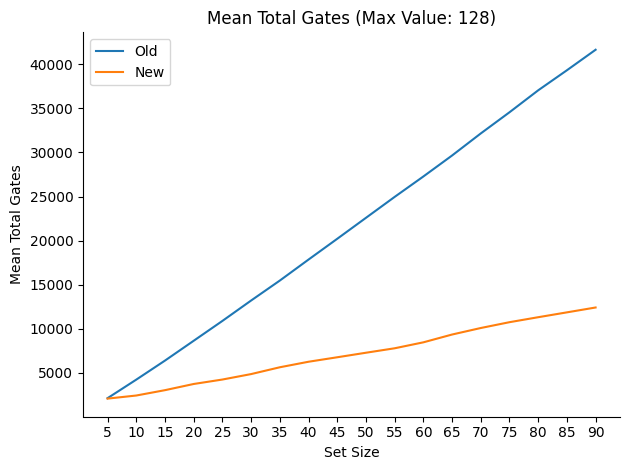

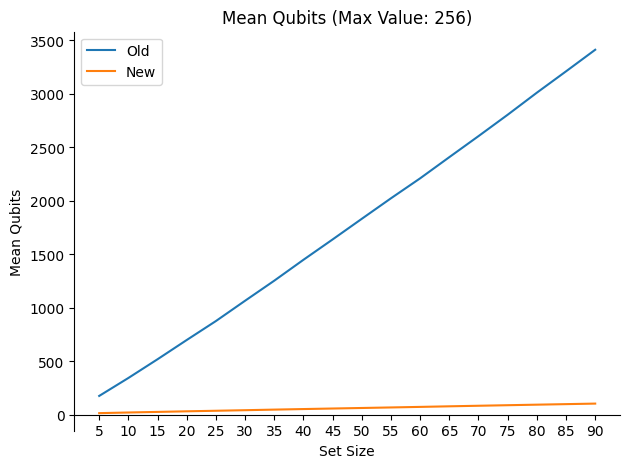

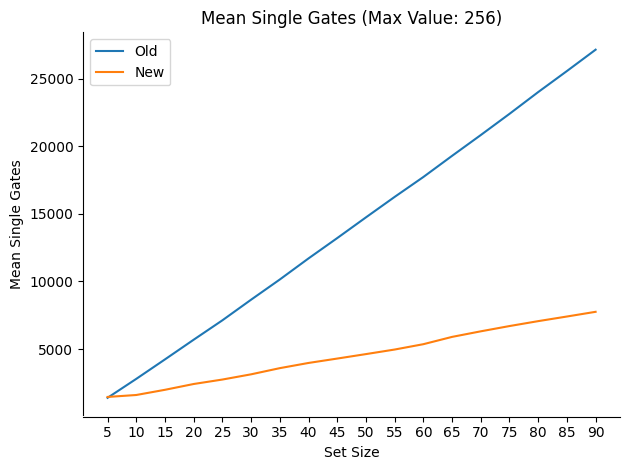

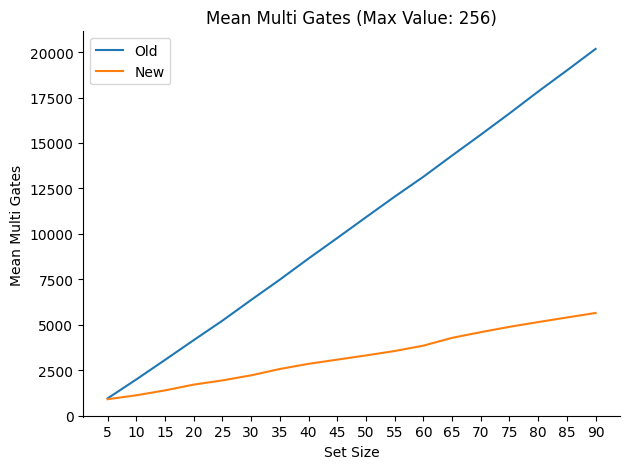

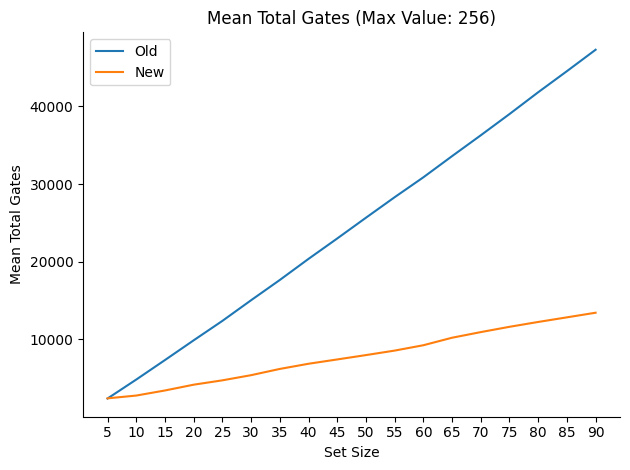

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

max_values = [64, 128, 256]
set_sizes = np.arange(5, 95, 5)

# Metrics definition: key, column(s), label for y-axis, title
metrics = [
    ('qubits', ['qubits'], 'Mean Qubits', 'Mean Qubits'),
    ('singleGates', ['singleGates'], 'Mean Single Gates', 'Mean Single Gates'),
    ('multiGates', ['multiGates'], 'Mean Multi Gates', 'Mean Multi Gates'),
    ('totalGates', ['singleGates', 'multiGates'], 'Mean Total Gates', 'Mean Total Gates')
]

for val in max_values:
    results = {key: {'old': [], 'new': []} for key, *_ in metrics}
    for size in set_sizes:
        data_old = pd.read_csv(f"./tests/{size}vals{val}max_old.csv")
        data_new = pd.read_csv(f"./tests/{size}vals{val}max_new.csv")
        # For each metric, compute mean(s)
        for key, cols, *_ in metrics:
            if key != 'totalGates':
                results[key]['old'].append(data_old[cols[0]].mean())
                results[key]['new'].append(data_new[cols[0]].mean())
            else:
                # Sum means for totalGates
                old_sum = data_old['singleGates'].mean() + data_old['multiGates'].mean()
                new_sum = data_new['singleGates'].mean() + data_new['multiGates'].mean()
                results[key]['old'].append(old_sum)
                results[key]['new'].append(new_sum)
    # Plot
    for key, _, ylabel, title in metrics:
        fig, ax = plt.subplots()
        ax.plot(set_sizes, results[key]['old'], label='Old')
        ax.plot(set_sizes, results[key]['new'], label='New')
        ax.set_xlabel('Set Size')
        ax.set_ylabel(ylabel)
        ax.set_title(f"{title} (Max Value: {val})")
        ax.legend()
        ax.set_xticks(set_sizes)
        # Spines and x-axis at y=0
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_position('zero')

        plt.tight_layout()
        fig.savefig(f"{title.replace(" ", "_")}_{val}.png")

In [43]:
instances = [
    [[1, 2, 4, 5], 5, 2],
    [[1, 2, 4, 5], 8, 2],
    [[1, 2, 4, 5], 18, 1],
    [[3, 5, 8], 8, 1],
    [[3, 5, 8], 11, 2],
    [[3, 5, 8], 12, 1],
    [[1, 2, 5, 7], 7, 2],
    [[1, 2, 5, 7], 15, 1],
    [[1, 2, 5, 7], 4, 1],
    [[1, 2, 3, 4, 4, 5, 9, 9, 9, 11], 6, 8],
    [[1, 2, 3, 4, 4, 5, 9, 9, 9, 11], 1, 16],
    [[1, 2, 3, 4, 4, 5, 9, 9, 9, 11], 58, 1],
    [[1, 1, 1, 2, 7, 9], 9, 2],
    [[1, 1, 1, 2, 7, 9], 5, 4],
    [[1, 1, 1, 2, 7, 9], 6, 1]
]

df_old = pd.DataFrame(columns=["Serial", "qubits", "single_gates", "multi_gates", "depth"])
df_new_no_uncompute = pd.DataFrame(columns=["Serial", "qubits", "single_gates", "multi_gates", "depth"])
df_new_uncompute = pd.DataFrame(columns=["Serial", "qubits", "single_gates", "multi_gates", "depth"])

for serial, instance in enumerate(instances):
    orcl_new_uncompute = oracle(instance[0], instance[1], old=True, uncompute=True)
    orcl_new_no_uncompute = oracle(instance[0], instance[1], old=True, uncompute=False)
    
    qubits_new_uncompute = orcl_new_uncompute.num_qubits
    qubits_new_no_uncompute = orcl_new_no_uncompute.num_qubits
    
    gates_new_uncompute = qiskit.transpile(orcl_new_uncompute, basis_gates=["h", "cx", "p"]).count_ops()
    gates_new_no_uncompute = qiskit.transpile(orcl_new_no_uncompute, basis_gates=["h", "cx", "p"]).count_ops()

    depth_new_no_uncompute = qiskit.transpile(orcl_new_no_uncompute, basis_gates=["h", "cx", "p"]).depth()
    depth_new_uncompute = qiskit.transpile(orcl_new_uncompute, basis_gates=["h", "cx", "p"]).depth()
    
    single_gates_new_no_uncompute = 0
    multi_gates_new_no_uncompute = 0
    for key,val in zip(gates_new_no_uncompute.keys(), gates_new_no_uncompute.values()):
        if key == "cx":
            multi_gates_new_no_uncompute += val
        else:
            single_gates_new_no_uncompute += val

    single_gates_new_uncompute = 0
    multi_gates_new_uncompute = 0

    for key,val in zip(gates_new_uncompute.keys(), gates_new_uncompute.values()):
        if key == "cx":
            multi_gates_new_uncompute += val
        else:
            single_gates_new_uncompute += val

    orcl_old = QSubsetSum(instance[0], instance[1])
    ans = orcl_old.run(True, True, True, True) #varArith with sorted values and partial sum

    depth_old = qiskit.transpile(orcl_old.qc.qcx, basis_gates=["h", "cx", "p"]).depth()
    df_old.loc[serial] = [serial+1] + list(ans) + [depth_old]
    
    df_new_uncompute.loc[serial] = [serial+1, orcl_new_uncompute.num_qubits, single_gates_new_uncompute, multi_gates_new_uncompute, depth_new_uncompute]
    df_new_no_uncompute.loc[serial] = [serial+1, orcl_new_uncompute.num_qubits, single_gates_new_no_uncompute, multi_gates_new_no_uncompute, depth_new_no_uncompute]
display(df_old, df_new_no_uncompute, df_new_uncompute)
df_old.to_csv('old.csv', index=False) 
df_new_no_uncompute.to_csv("new_no.csv", index=False)
df_new_uncompute.to_csv("new_with.csv", index=False)

,Serial,qubits,single_gates,multi_gates,depth
0,1,54,385,243,358
1,2,54,382,243,358
2,3,54,382,243,358
3,4,56,401,251,370
4,5,56,407,251,370
5,6,56,404,251,370
6,7,56,405,251,371
7,8,56,408,251,371
8,9,56,399,251,371
9,10,167,1292,903,1303


,Serial,qubits,single_gates,multi_gates,depth
0,1,8,272,153,305
1,2,8,266,153,304
2,3,9,350,211,401
3,4,8,457,241,431
4,5,8,463,241,431
5,6,8,460,241,431
6,7,8,312,165,333
7,8,8,312,165,333
8,9,8,306,165,333
9,10,16,652,373,662


,Serial,qubits,single_gates,multi_gates,depth
0,1,8,397,202,374
1,2,8,385,202,370
2,3,9,512,286,492
3,4,8,624,314,534
4,5,8,636,314,534
5,6,8,630,314,534
6,7,8,476,226,430
7,8,8,476,226,430
8,9,8,464,226,430
9,10,16,1079,578,940


In [53]:
cols = ["qubits", "single_gates", "multi_gates", "depth"]
comp = df_old.copy()
comp[cols] = df_old[cols] - df_new_no_uncompute[cols]
comp.to_csv("comp.csv", index=False)